In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import models
import data
import train_metrics
from IPython.display import clear_output

In [2]:
batch_size = 8
epochs = 50
learning_rate = 3e-4

In [ ]:
# load data and create dataloader
files_sat_train = [os.path.join('./data/train/sat',f) for f in os.listdir('./data/train/sat')] 
files_mask_train = [os.path.join('./data/train/mask',f) for f in os.listdir('./data/train/mask')] 

files_sat_val = [os.path.join('./data/val/sat',f) for f in os.listdir('./data/val/sat')] 
files_mask_val = [os.path.join('./data/val/mask',f) for f in os.listdir('./data/val/mask')] 

dataset = {
   'train': data.Dataset(files_sat_train,files_mask_train),
   'val': data.Dataset(files_sat_val,files_mask_val)
}

dataloader = {
   'train': DataLoader(dataset['train'], batch_size=batch_size, shuffle=True),
   'val': DataLoader(dataset['val'], batch_size=batch_size, shuffle=True)
}

In [4]:
# load model to gpu
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
unet = models.UNet(3,1) # 3 input channels / 1 output channel
unet = unet.to(device)

In [5]:
def plot_val_images(model, dl_val):
    """ plot some validation images and predictions during training"""
    saved_images_count = 0
    val_images = 15
    col_names = ["Real Image", "Ground Truth", "UNet"]
    real_image = []
    ground_truth = []
    prediction = []
    unet.eval()
    with torch.no_grad():
        for imgs, masks in dl_val:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            for i in range(len(preds)):
                saved_images_count += 1
                real_image.append(np.transpose(imgs[i].cpu().detach().numpy(), (1,2,0)))
                ground_truth.append(np.transpose(masks[i].cpu().detach().numpy(), (1,2,0)))
                prediction.append(np.transpose(preds[i].cpu().detach().numpy(), (1,2,0)))
                if saved_images_count >val_images: 
                    fig, axs = plt.subplots(nrows=val_images,ncols=3, figsize=(6, int(val_images*2)))
                    for j in range(val_images):
                        axs[j,0].imshow(real_image[j])
                        axs[j,0].set_axis_off()

                        axs[j,1].imshow(ground_truth[j], vmin=0, vmax=1, cmap = "Blues_r")
                        axs[j,1].set_axis_off()

                        axs[j,2].imshow(prediction[j], vmin=0, vmax=1, cmap = "Blues_r")
                        axs[j,2].set_axis_off()

                    for ax, col in zip(axs[0], col_names):
                        ax.set_title(col, color="white")

                    fig.patch.set_facecolor('black')
                    fig.tight_layout()
                    plt.show()

                    return ground_truth, prediction

In [6]:
def fit_unet(model, dataloader, epochs, initial_lr):
    """ train unet """
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.45)
    criterion = torch.nn.BCEWithLogitsLoss()
    metrics = {'train_loss': [], 'val_loss': [],'train_dice': [], 'val_dice': [],'train_iou': [], 'val_iou': []}
    for epoch in range(1,epochs+1):
        bar = tqdm(dataloader['train'], position=0, leave=True)
        bar.set_description(f"Train Epoch: {epoch}")
        total_examples = 0
        loss_epoch = 0.0
        iou = 0.0
        dice = 0.0
        model.train()
        #### train loop
        for imgs, masks in bar:
            imgs, masks = imgs.to(device), masks.to(device)
            optimizer.zero_grad()
            preds = model(imgs)
            loss = criterion(preds, masks)
            loss.backward()
            optimizer.step()
            loss_epoch += loss.item()
            for j in range(len(imgs)):
                total_examples += 1
                iou += train_metrics.iou_coeff(preds[j], masks[j]).cpu().detach().numpy()
                dice += train_metrics.dice_coeff(preds[j], masks[j]).cpu().detach().numpy()
        
        # lr scheduler step every 10 epochs
        if epoch % 10 == 0:
            lr_scheduler.step()
                
        # epoch mean training metrics
        metrics["train_loss"].append(loss_epoch/batch_size)
        metrics["train_iou"].append(iou/total_examples)
        metrics["train_dice"].append(dice/total_examples)

        #### val loop
        bar = tqdm(dataloader['val'])
        bar.set_description(f"Val Epoch: {epoch}")
        total_examples = 0
        loss_epoch = 0.0
        iou = 0.0
        dice = 0.0
        model.eval()
        with torch.no_grad():
            for imgs, masks in bar:
                imgs, masks = imgs.to(device), masks.to(device)
                preds = model(imgs)
                loss = criterion(preds, masks)
                loss_epoch += loss.item()
                for j in range(len(imgs)):
                    total_examples += 1
                    iou += train_metrics.iou_coeff(preds[j], masks[j]).cpu().detach().numpy()
                    dice += train_metrics.dice_coeff(preds[j], masks[j]).cpu().detach().numpy()
                
        # epoch mean validation metrics
        metrics["val_loss"].append(loss_epoch/batch_size)
        metrics["val_iou"].append(iou/total_examples)
        metrics["val_dice"].append(dice/total_examples)
        
        # save model if performance improved
        #if hist["val_loss"][-1] == np.min(hist["val_loss"]):
        #    torch.save(model.state_dict(), f'./saved_models/UNet.pkl')  

        clear_output(wait=True)
        train_metrics.plot_metrics(metrics)
        plot_val_images(model, dataloader['val'])

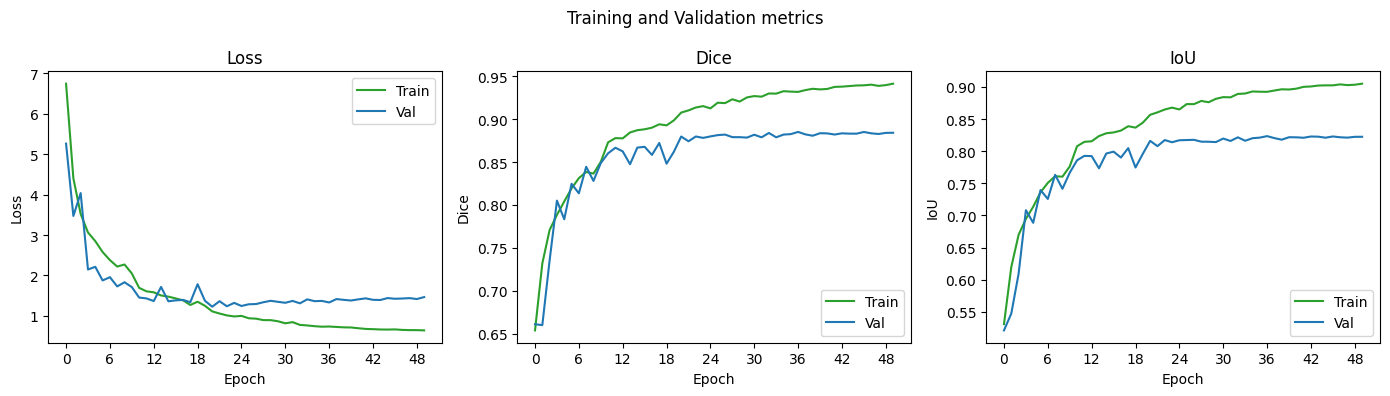

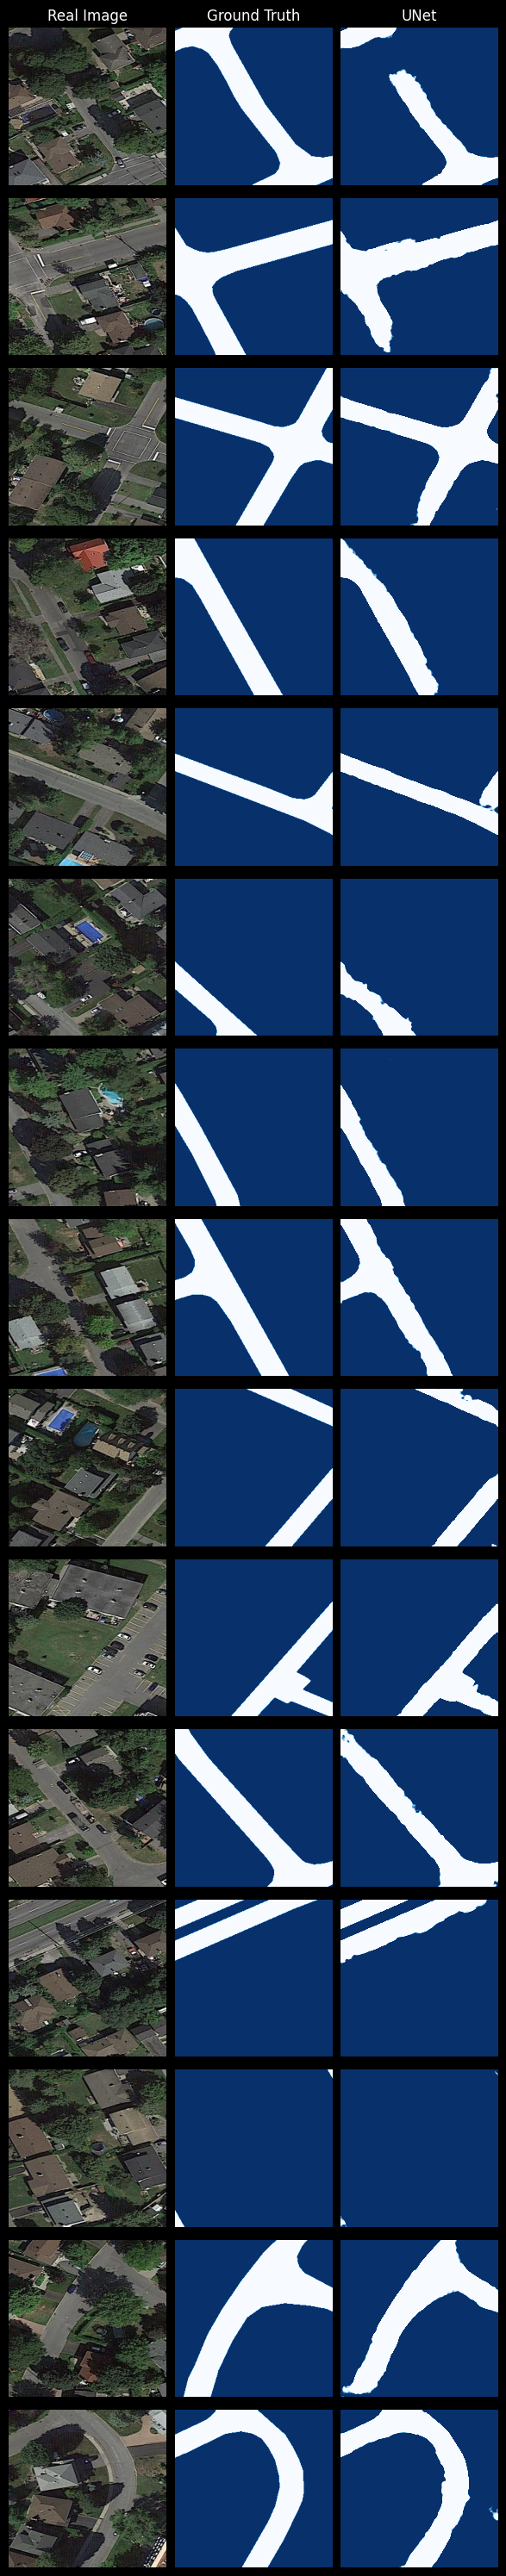

In [10]:
fit_unet(unet, dataloader, epochs, learning_rate)